# Clasificación de reclamos

## Introducción

A partir de un conjunto de **reclamos** del banco *Well's Fargo*, tenemos como objetivo el crear un modelo de clasificación que permita reconocer los distintos productos y sub-productos a los que se hacen referencia en dicho reclamo.

## 1.  Preparación de los datos

Durante esta sección se abarca todo lo relacionado la limpieza de datos no deseados en nuestro modelo, y luego, el procesamiento de dicho conjunto de datos para que adquieran importancia y puedan ser utilizados para entrenar un modelo de clasificación

In [1]:
import nltk
import re

import pandas as pd

from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from matplotlib import pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.simplefilter('ignore')

Importamos el conjunto de datos del banco Well's Fargo, y mantenemos únicamente las columnas de *producto, sub-producto y reclamos* ya que son aquellas de más importancia para nuestro estudio.

In [2]:
df = pd.read_csv('wells_fargo.csv')
df = df[['Product', 'Sub-product','Consumer complaint narrative']]

#Rename Consumer complaint narrative to complaint
df.rename(columns={'Consumer complaint narrative':'complaint'}, inplace=True)

df.sample(5)

,Product,Sub-product,complaint
2844,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,My Wells Fargo checking account ( ending in XX...
1456,"Credit reporting, credit repair services, or o...",Credit reporting,I have these accounts that are not mine adn iw...
1648,"Credit reporting, credit repair services, or o...",Credit reporting,I disputed this account several times with no ...
36,Checking or savings account,Checking account,The claim number with wells fargo is # XXXX {$...
146,Checking or savings account,Checking account,As a consumer Wells Fargo Violated several con...


Es importante remarcar que los datos ya fueron previamente balanceados y estan repartidos en una muestra equitativa de productos, y sub-productos.

In [3]:
df.groupby('Product').count()

,Sub-product,complaint
Product,,
Checking or savings account,600,600
Credit card or prepaid card,600,600
"Credit reporting, credit repair services, or other personal consumer reports",600,600
"Money transfer, virtual currency, or money service",600,600
Mortgage,600,600
Vehicle loan or lease,559,559


In [4]:
df.groupby(['Product','Sub-product']).count()

complaint
Product                                            Sub-product                                          
Checking or savings account                        Checking account                                  200
                                                   Other banking product or service                  200
                                                   Savings account                                   200
Credit card or prepaid card                        General-purpose credit card or charge card        600
Credit reporting, credit repair services, or ot... Credit reporting                                  600
Money transfer, virtual currency, or money service Domestic (US) money transfer                      300
                                                   Mobile or digital wallet                          300
Mortgage                                           Conventional home mortgage                        120
                                                   FHA mortgage                                      120
                                                   Home equity loan or line of credit (HELOC)        120
                                                   Other type of mortgage                            120
                                                   VA mortgage                                       120
Vehicle loan or lease                              Loan                                              559

### 1.1  Limpieza de los datos

La limpieza de datos consiste en quitar aquellos caracteres y palabras que van a influir negativamente en nuestro modelo de predicción. A partir de estudiar los datos, se decidió eliminar:

- Palabras vacías (Stopwords)
- Salto de líneas
- Carácteres de puntuación
- La letra X 
- Reemplazar {＄0.00}, pudiendo tener cualquier valor númerico en su interior, a ＄
- El nombre Well's Fargo
- Números

In [5]:
def cleaned_text(string):
    """
    This function cleans the text by removing or replacing some characters and numbers 
    """
    
    #Removing \n
    string = string.replace('\n', '')

    #Replacing {$...} with $
    string = re.sub('\{\$[\d.]+\}', ' $ ', string)

    #Removing punctuations and special characters
    string = re.sub("[\.|,!:;\)\(\[\]{}%’“”\-—#&@\?¿¡/\\\*\+~_><`'\"]", ' ', string)

    #Removing Xs
    string = string.replace('X', ' ') 

    #Removing numbers
    string = re.sub('\d', ' ', string)

    #Removing single characters
    string = re.sub('\s[a-zA-Z]\s', ' ', string)

    #Removing Well's Fargo and its variations
    string = string.replace('well fargo', ' ').replace('wells fargo', ' ').replace('wellsfargo', ' ').replace('wellfargo',' ')

    #removing multiple spaces
    string = re.sub('\s+', ' ', string)
    

    return string.strip().lower()

df['complaint'] = df['complaint'].apply(cleaned_text)

df.sample(5)

,Product,Sub-product,complaint
533,Checking or savings account,Savings account,on the date of was taking out of my savings an...
3068,Vehicle loan or lease,Loan,in my credit report started reading that my ca...
1249,"Credit reporting, credit repair services, or o...",Credit reporting,i have filed dispute in regards to the incorre...
3000,Vehicle loan or lease,Loan,on call was placed to wells fargo dealer servi...
2680,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,for the past several years my social security ...


### 1.2  Lematización

La lematización es un proceso donde, a partir una forma conjugada de la palabra, se busca llegar al lema, el cual es el representante o palabra raíz de las conjugaciones de estas. Dicho proceso busca simplificar las palabras perdurando su contexto, lo que facilita su análisis a nivel computacional.

In [6]:
stop_words = stopwords.words('english') + ['itll','well','wells','fargo']

lemmatizer = WordNetLemmatizer()

def lemma_pos(token_and_pos):
    """
    Lemmatizing by part of speech
    """
    word, pos = token_and_pos
    lemma_dict = {'N': 'n', 'V': 'v', 'J': 'a', 'R': 'r'}
    return lemmatizer.lemmatize(word, lemma_dict.get(pos[0], 'n'))
            

def lemmatizing(string):   
    """
    This function preprocesses the text by tokenizing, removing stop words, lemmatizing and joining tokens back together
    """
    text =''

    #Splitting into sentences
    sentences = sent_tokenize(string)

    for sentence in sentences:
        
        #Tokenizing, lowering and part of speech tagging
        tokens = word_tokenize(sentence)
        tokens = pos_tag(tokens)

        #Removing stop words
        tokens = [token for token in tokens if token[0] not in stop_words and len(token[0])>2 and token[0] != '$']
        
        #Lemmatizing by part of speech
        tokens = [lemma_pos(token) for token in tokens if token[0]]
        text += ' '.join(tokens)

    return text


df['complaint'] = df['complaint'].apply(lemmatizing)

df.sample(5)

,Product,Sub-product,complaint
2966,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,receive text state zelle transfer try process ...
1316,"Credit reporting, credit repair services, or o...",Credit reporting,refuse face responsibility inflict pain suffer...
2062,Credit card or prepaid card,General-purpose credit card or charge card,wellsfargo violate close consumer credit trans...
567,Checking or savings account,Savings account,recently scammed pay scam text supposedly frau...
3180,Vehicle loan or lease,Loan,charge late fee since every month never late f...


### 1.3  Separación de conjuntos

Separamos nuestro conjunto de prueba y entrenamiento en una relación de (20%-80%), teniendo en cuenta el conjunto de productos y subproductos.

In [7]:
df_test = pd.DataFrame()
df_train = pd.DataFrame()

for subproduct in df['Sub-product'].unique():
    train, test = train_test_split(df[df['Sub-product'] == subproduct], test_size=0.2, random_state=42)
    df_train = pd.concat([df_train, train])
    df_test = pd.concat([df_test, test])


### 1.4  Extracción de tópicos  

La extracción de tópicos se basa en la ley de Zpif, el cual hace enfasis en que las palabras menos repetidas en un texto son las que contienen mayor información, o por su contraparte, las palabras más repetidas son las que aportan menos carga informativa, las que también son conocidas como palabras vacías.

A partir de estudiar los datos y hacer pruebas en los modelos, usamos dicho método para extraer los 6 tópicos (conjunto de palabras representativas) presentes en el conjunto de reclamos, y asignar el porcentaje de cada tópico a cada reclamo.

In [8]:
lda_count_vectorizer = CountVectorizer(lowercase=False, tokenizer=word_tokenize)
lda_count_vectorizer.fit(df_train['complaint'])

df_train_vector = lda_count_vectorizer.transform(df_train['complaint'])

lda_model = LatentDirichletAllocation(n_components=6, random_state=8, max_iter=20, learning_method='online')
lda_model.fit(df_train_vector)


def get_topics(df, lda_model, lda_vectorizer):

    lda_vectors = lda_vectorizer.transform(df['complaint'])
    topics = lda_model.transform(lda_vectors)
    topics = topics.tolist()

    topics = [pd.Series(topic) for topic in topics]

    lda_columns =['lda_product_0','lda_product_1','lda_product_2','lda_product_3','lda_product_4','lda_product_5']
    df[lda_columns] = topics

    return df

df_train_count = get_topics(df_train, lda_model, lda_count_vectorizer)
df_test_count = get_topics(df_test, lda_model, lda_count_vectorizer)

df_train_count.sample(5)

,Product,Sub-product,complaint,lda_product_0,lda_product_1,lda_product_2,lda_product_3,lda_product_4,lda_product_5
234,Checking or savings account,Other banking product or service,insecure bank industry complaint fraudulent tr...,0.004021,0.980092,0.003968,0.003982,0.003968,0.003969
1550,"Credit reporting, credit repair services, or o...",Credit reporting,accordance fair credit reporting act account v...,0.976783,0.004671,0.004630,0.004657,0.004630,0.004630
617,Mortgage,Conventional home mortgage,home loan sell past couple year send notice ne...,0.001220,0.505062,0.001208,0.490093,0.001209,0.001208
1385,"Credit reporting, credit repair services, or o...",Credit reporting,wellsfargo bank contact autherize inqury open ...,0.832746,0.009907,0.009804,0.009832,0.009804,0.127906
213,Checking or savings account,Other banking product or service,bank respond multiple request provide access s...,0.001505,0.992530,0.001493,0.001496,0.001488,0.001488


### 1.4  Vectorización


La vectorización, como su nombre lo dice, consiste en transformar las oraciones a una forma vectorial para que pueda ser procesado a nivel computacional. 

Esta vectorización la vamos a hacer a partir de un Count Vectorizer, un algoritmo que convierte a vectores nuestro conjunto de palabras, segun la cantidad de apariciones que tuvo cada palabra. Además de la frecuencia de aparición de cada palabra, vamos a tener en cuenta los bigramas (uniones de dos palabras contiguas) que estan formados por:
- Sustantivo + Sustantivo
- Adjetivo + Sustantivo
- Verbo + Sustantivo
- Sustantivo + Verbo

In [9]:
def bigram_tokenizer(string):
    """
    Receives a string and returns a list of tokens and bigrams
    """
    tokens = []
    words = word_tokenize(string)
    pos = nltk.pos_tag(words)
    
    #Looping through the words
    for i in range(len(words) - 1):

        #Checking if the two contiguous words are nouns, verbs or adjectives
        if pos[i][1][0] + pos[i + 1][1][0] in ['NN', 'JN', 'VN', 'NV']:
            tokens.append(words[i] + ' ' + words[i + 1])
        
        tokens.append(words[i])
    
    tokens.append(words[-1])
    return tokens

#Creating a count vectorizer instance with bigrams and training it
count_vectorizer = count_vectorizer = CountVectorizer(lowercase=False, tokenizer=bigram_tokenizer, min_df=10)
count_vectorizer.fit(df_train['complaint'])


def vectorize(df, vectorizer):
    """
    This function receives a dataframe and a vectorizer and returns a dataframe with the vectorized text
    """

    #Transforming the text into vectors
    vectors = vectorizer.transform(df['complaint'])
    vectorized_df = pd.DataFrame(vectors.toarray())
    
    #Joining the rest of the dataframe with vectorized texts 
    lda_columns =['lda_product_0','lda_product_1','lda_product_2','lda_product_3','lda_product_4','lda_product_5']
    for lda_column in lda_columns:
        vectorized_df[lda_column] = df[lda_column].values

    vectorized_df['complaint'] = df['complaint'].values
    vectorized_df['product'] = df['Product'].values
    vectorized_df['subproduct'] = df['Sub-product'].values
    
    return vectorized_df

df_train_count = vectorize(df_train, count_vectorizer)
df_test_count = vectorize(df_test, count_vectorizer)

df_train_count.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,3773,lda_product_0,lda_product_1,lda_product_2,lda_product_3,lda_product_4,lda_product_5,complaint,product,subproduct
1907,0,0,0,0,0,0,0,0,0,0,...,0,0.907286,0.018592,0.018519,0.018566,0.018519,0.018519,formal request investigation account possibili...,Credit card or prepaid card,General-purpose credit card or charge card
2710,0,0,0,0,0,0,0,0,0,0,...,0,0.032078,0.212168,0.001587,0.750989,0.001587,0.001590,company charge lates fee access total balance ...,Vehicle loan or lease,Loan
447,0,0,0,0,0,0,0,0,0,0,...,0,0.004795,0.976132,0.004762,0.004784,0.004762,0.004764,two amount withdraw save account person regist...,Checking or savings account,Savings account
1542,0,0,0,0,0,0,0,0,0,0,...,0,0.219605,0.767777,0.003163,0.003166,0.003145,0.003145,receive credit card offer mail bank fill onlin...,Credit card or prepaid card,General-purpose credit card or charge card
857,0,0,0,0,0,0,0,0,0,0,...,0,0.001626,0.001636,0.001618,0.991873,0.001629,0.001618,successor interest loan suffered covid hardshi...,Mortgage,Home equity loan or line of credit (HELOC)


## 2.  Modelos predictivos

Luego de haber preparado el conjunto de datos, procedemos a buscar los modelos de clasificación óptimos para la categorización de reclamos. Para esto vamos a entrenar dos modelos. 

El primer modelo esta enfocado en identificar a que producto pertenece dicho reclamo, luego de haber clasificado el producto al que pertenece el reclamo, se utiliza el resultado de esta clasificación como un nuevo dato para el entrenamiento del segundo modelo, el cual se encarga de predecir el sub-producto correspondiente al reclamo.

Para ambos modelos vamos a probar con tres algoritmos diferentes, y en base a las métricas obtenidas, vamos a elegir un único algoritmo, el cual va a ser el que tenga mejor desempeño en la clasificación. Los modelos que vamos a utilizar son:
- Logistic Regression
- Support Vectors Machines
- CatBoost

In [10]:
def print_confusion_matrix(model, y_test, y_pred):
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


### 2.1  Predicción del producto

In [11]:
x_train = df_train_count.drop(['complaint', 'product', 'subproduct'], axis=1)
y_train = df_train_count['product']

x_test = df_test_count.drop(['complaint', 'product', 'subproduct'], axis=1)
y_test = df_test_count['product']


x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)

#### Logistic Regression

Accuracy:  0.7598314606741573
Accuracy train:  0.8328064629434493
                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.66      0.74      0.70       120
                                                 Credit card or prepaid card       0.78      0.74      0.76       120
Credit reporting, credit repair services, or other personal consumer reports       0.67      0.75      0.71       120
                          Money transfer, virtual currency, or money service       0.77      0.74      0.75       120
                                                                    Mortgage       0.89      0.84      0.86       120
                                                       Vehicle loan or lease       0.83      0.74      0.78       112

                                                                    accuracy                           0.7

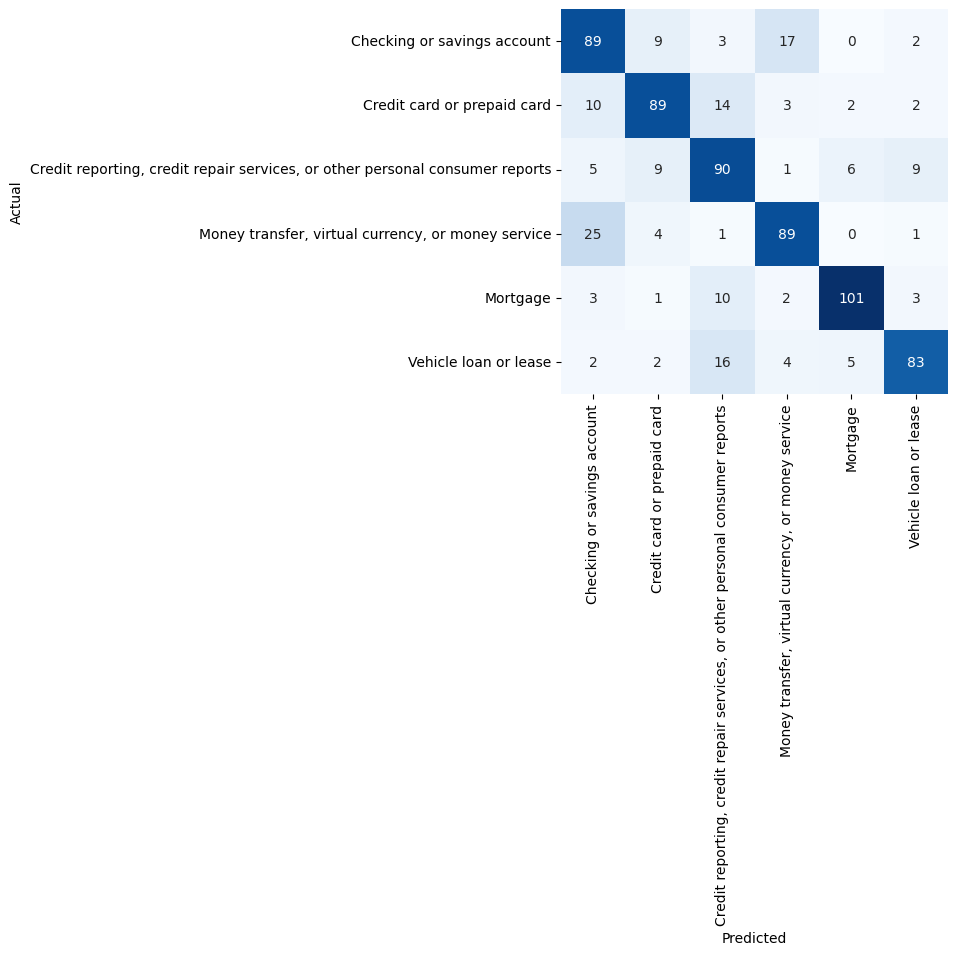

In [13]:
lr = LogisticRegression(C=2, max_iter=60, solver='saga', random_state=42)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, lr.predict(x_train))
print('Accuracy: ', accuracy)
print('Accuracy train: ', accuracy_train)
print_confusion_matrix(lr, y_test, y_pred)

#### Support Vector Machine

Accuracy:  0.7275280898876404
Accuracy on train:  0.8658236740428521
                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.63      0.73      0.68       120
                                                 Credit card or prepaid card       0.79      0.65      0.71       120
Credit reporting, credit repair services, or other personal consumer reports       0.66      0.78      0.72       120
                          Money transfer, virtual currency, or money service       0.77      0.67      0.71       120
                                                                    Mortgage       0.76      0.82      0.79       120
                                                       Vehicle loan or lease       0.81      0.71      0.76       112

                                                                    accuracy                           

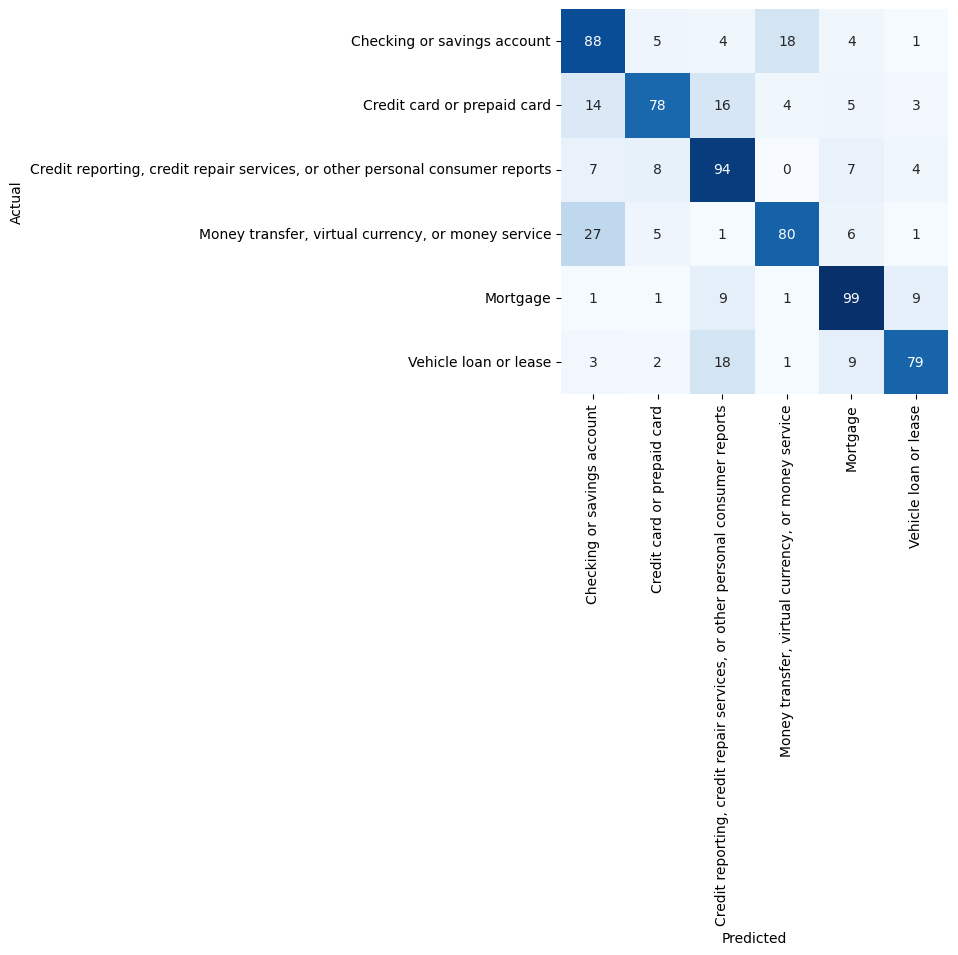

In [14]:
svc = SVC(kernel= 'rbf', degree=4, random_state=42)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, svc.predict(x_train))
print('Accuracy: ', accuracy)
print('Accuracy on train: ', accuracy_train)
print_confusion_matrix(svc, y_test, y_pred)

#### CatBoost

Accuracy:  0.773876404494382
Accuracy on train set:  0.8349139445029856
                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.71      0.72      0.72       120
                                                 Credit card or prepaid card       0.80      0.73      0.77       120
Credit reporting, credit repair services, or other personal consumer reports       0.70      0.77      0.73       120
                          Money transfer, virtual currency, or money service       0.77      0.74      0.76       120
                                                                    Mortgage       0.85      0.88      0.86       120
                                                       Vehicle loan or lease       0.81      0.80      0.81       112

                                                                    accuracy                        

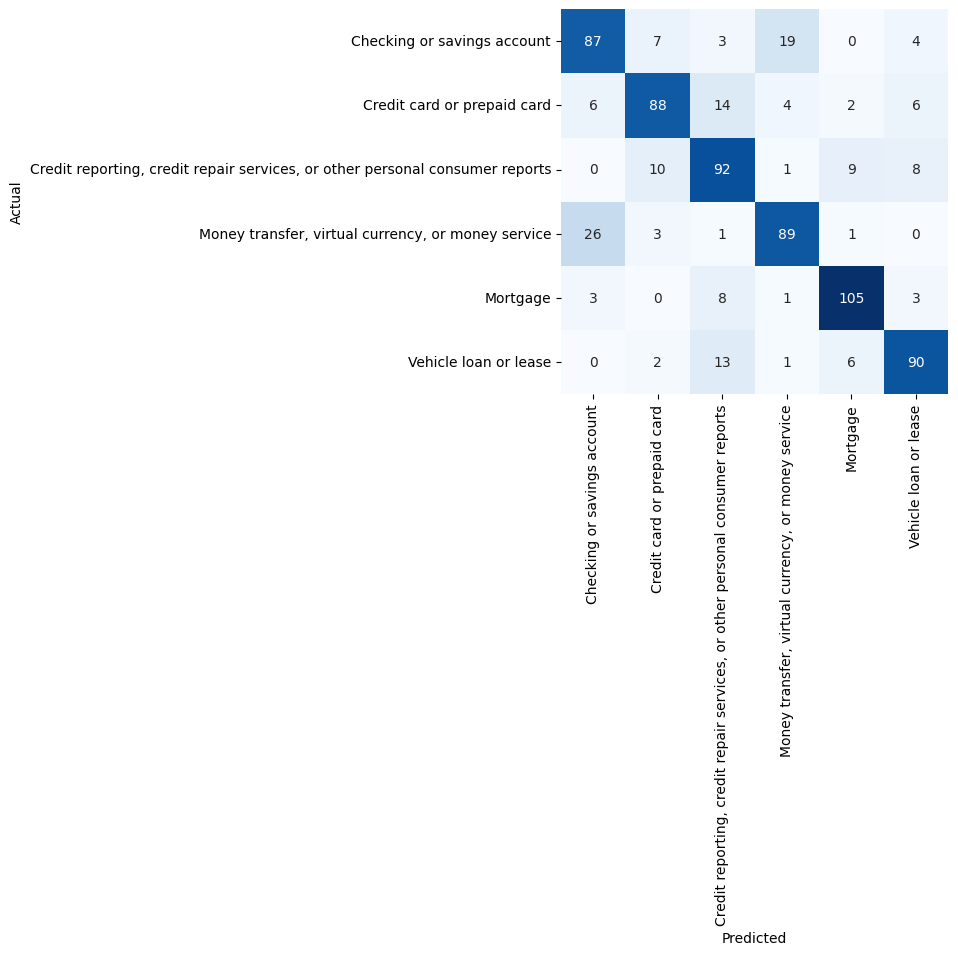

In [15]:
model = CatBoostClassifier(iterations = 550, depth =4, random_seed=84, loss_function='MultiClass', silent=True)
model.fit(x_train, df_train_count['product'])
pred_y = model.predict(x_test)
catboost_accuracy = accuracy_score(y_test, pred_y)
catboost_accuracy_train = accuracy_score(y_train, model.predict(x_train))
print('Accuracy: ', catboost_accuracy)
print('Accuracy on train set: ', catboost_accuracy_train)
print_confusion_matrix(model, y_test, pred_y)

Comparando las métricas de los tres algoritmos, vemos que el CatBoost fue el modelo que mejor se ha desempeñado en la clasificación, por lo tanto vamos a elegir este para la predicción de productos.

Entonces, unimos las predicciones obtenidas del CatBoost durante la clasificación del producto y las agregamos a nuestro conjunto de datos, así luego podemos utilizar esta información para la predicción de sub-productos.

Aquellos productos como *Vehicle loan or lease predicted subproduct*, *Credit card or prepaid card*, y *Credit reporting, credit repair services, or other personal consumer reports*, que poseen un único sub-producto, se le asignan directamente sus sub-productos correspondientes

In [16]:
#Append predicted product to dataframes
df_train_count['predicted product'] = [x[0] for x in model.predict(x_train)]
df_test_count['predicted product'] = [x[0] for x in model.predict(x_test)]

#Train dataframe with only one subproduct
df_train_count.loc[df_train_count['predicted product']=='Credit reporting, credit repair services, or other personal consumer reports', 'predicted subproduct'] = "Credit reporting"

df_train_count.loc[df_train_count['predicted product']=='Credit card or prepaid card', 'predicted subproduct'] = "General-purpose credit card or charge card"

df_train_count.loc[df_train_count['predicted product']=='Vehicle loan or lease', 'predicted subproduct'] = "Loan"

#Test dataframe with only one subproduct
df_test_count.loc[df_test_count['predicted product']=='Credit reporting, credit repair services, or other personal consumer reports', 'predicted subproduct'] = "Credit reporting"

df_test_count.loc[df_test_count['predicted product']=='Credit card or prepaid card', 'predicted subproduct'] = "General-purpose credit card or charge card"

df_test_count.loc[df_test_count['predicted product']=='Vehicle loan or lease', 'predicted subproduct'] = "Loan"

### 2.2  Predicción del subproducto


Eliminamos las columnas que queremos predecir y además quitamos del conjunto de datos aquellos productos que tengan un único sub-producto

In [17]:
unique_subproducts = ['Credit reporting, credit repair services, or other personal consumer reports','Credit card or prepaid card','Vehicle loan or lease']

df_train = df_train_count[~df_train_count['predicted product'].isin(unique_subproducts)]
df_test = df_test_count[~df_test_count['predicted product'].isin(unique_subproducts)]

x_train = df_train_count.drop(['complaint', 'product', 'subproduct','predicted product', 'predicted subproduct'], axis=1)
y_train = df_train_count['subproduct']
x_test = df_test_count.drop(['complaint', 'product', 'subproduct','predicted product', 'predicted subproduct'], axis=1)
y_test = df_test_count['subproduct']

x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)


In [18]:
def get_subproduct_metrics(y_test, pred_y, y_train, pred_train_y):
    """
    Returns metrics for subproduct classification knowing that the product is well classified
    """
    accuracy = accuracy_score(y_test, pred_y) / catboost_accuracy
    accuracy_train = accuracy_score(y_train, pred_train_y) / catboost_accuracy_train

    print('Accuracy: ', accuracy)
    print('Accuracy on train: ', accuracy_train)

#### Logistic Regression

In [19]:
lr = LogisticRegression(C=2, max_iter=40, solver='saga', random_state=42)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

get_subproduct_metrics(y_test, y_pred, y_train, lr.predict(x_train))

Accuracy:  0.7640653357531761
Accuracy on train:  0.8636937315944467


#### Support Vector Machine

In [20]:
svc = SVC(kernel='rbf', degree=6, random_state=42)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)

get_subproduct_metrics(y_test, y_pred, y_train, svc.predict(x_train))

Accuracy:  0.6987295825771326
Accuracy on train:  0.9360538493899874


#### CatBoost

In [21]:
model = CatBoostClassifier(iterations = 420, depth=4,silent=True, learning_rate=0.1, loss_function='MultiClass')
model.fit(x_train, df_train_count['subproduct'])
pred_y = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)

get_subproduct_metrics(y_test, pred_y, y_train, model.predict(x_train))

Accuracy:  0.7749546279491834
Accuracy on train:  0.8376104333193101


##  Conclusión

A partir del procesamiento de los datos, empezando desde la limpieza y pasando por diferentes métodos estadíos de procesamiento, logramos entrenar un modelo enfocado en la clasificación de los productos, el cual logra predecir correctamente con una tasa del 77% de aciertos. Luego con los resultados del primer modelo, fuimos  capaces de entrenar un segundo modelo, que utiliza el mismo algoritmo, para categorizar los sub-productos con una tasa de aciertos del 77% dado que el conjunto de los productos fue predicho correctamente.